## Dependencies

In [1]:
import os
os.chdir('../')

In [2]:
%pwd

'c:\\Projects\\python\\brain_tumor_segmentation'

In [3]:
from src.config.configuration import ConfigurationManager  # adjust import as needed
from src.model2 import UNetR2D
import torch
from torchvision.transforms import transforms
from src.utils import BrainTumorSegmentationDataset, CustomDataLoader
from torch.utils.data import random_split
import csv
from src.utils import BCEDiceLoss, dice_coefficient
import torch.optim as optim

# For testing, assume ConfigurationManager returns an instance of UNetRTrainerConfig.
config_manager = ConfigurationManager()
training_arguments = config_manager.get_UNetR_params()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
## Global parameters
H,W = 256,256
torch.manual_seed(42)
batch_size = 8
lr = 1e-3
num_epochs = 500
dataset_path = "./data/archive/"
model_dir = './models/model2/'
log_path = './logs/train_log_unetr_1.csv'
os.makedirs(model_dir,exist_ok=True)
model_path = os.path.join(model_dir, 'best_model2.pt')
print(device)

cuda


## Load Dataset

In [4]:
# Define transforms
transform = transforms.Compose([
    transforms.Resize((H, W)),
    transforms.ToTensor()
])

full_dataset = BrainTumorSegmentationDataset(
    image_dir=os.path.join(dataset_path, "images"), 
    mask_dir=os.path.join(dataset_path, "masks"),
    transform=transform
)

# Split dataset
train_size = int(0.95 * len(full_dataset))
valid_size = len(full_dataset) - train_size

train_dataset, valid_dataset = random_split(full_dataset, [train_size, valid_size])

train_loader = CustomDataLoader(train_dataset,batch_size=batch_size,shuffle=True)
valid_loader = CustomDataLoader(valid_dataset,batch_size=batch_size,shuffle=True)

## Trainer code

In [5]:
def train_UNet(model, train_loader, valid_loader, device, num_epochs=500, lr=1e-3,
               log_path='./logs/train_log2.csv', model_path='./models/model1/best_model2.pth',patience=50):
    # Use the combined BCE + Dice loss (ensure that BCEDiceLoss is defined/imported)
    criterion = BCEDiceLoss()
    
    # Adam with weight decay for regularization
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    
    # Cosine annealing scheduler
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-7)
    
    best_loss = float('inf')
    patience_counter = 0
    model.to(device)

    # Open log file and write header (including Valid Dice)
    with open(log_path, mode='w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(["Epoch", "Train Loss", "Valid Loss", "Valid Dice"])

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        total_train_samples = 0

        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            
            batch_size_curr = images.size(0)
            train_loss += loss.item() * batch_size_curr
            total_train_samples += batch_size_curr
        
        train_loss = train_loss / total_train_samples

        model.eval()
        valid_loss = 0.0
        total_valid_samples = 0
        valid_dice = 0.0

        with torch.no_grad():
            for images, masks in valid_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                loss = criterion(outputs, masks)
                
                batch_size_curr = images.size(0)
                valid_loss += loss.item() * batch_size_curr
                total_valid_samples += batch_size_curr

                # Compute dice coefficient for the batch and accumulate
                batch_dice = dice_coefficient(outputs, masks)
                valid_dice += batch_dice * batch_size_curr

        valid_loss = valid_loss / total_valid_samples
        valid_dice = valid_dice / total_valid_samples
        
        # Step the cosine annealing scheduler
        scheduler.step()

        with open(log_path, mode='a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow([epoch + 1, train_loss, valid_loss, valid_dice])

        if valid_loss < best_loss:
            best_loss = valid_loss
            torch.save(model.state_dict(), model_path)
            patience_counter=0
        else:
            patience_counter+=1
        
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, "
              f"Valid Loss: {valid_loss:.4f}, Valid Dice: {valid_dice:.4f}, Patience: {patience_counter}")

        if patience_counter>=patience:
            print('Early Stopping Triggered!')
            break


## Train

In [6]:
# model = UNetR2D(config=training_arguments)
# train_UNet(model, train_loader, valid_loader, device, num_epochs, lr, model_path=model_path, log_path=log_path)

## Training results

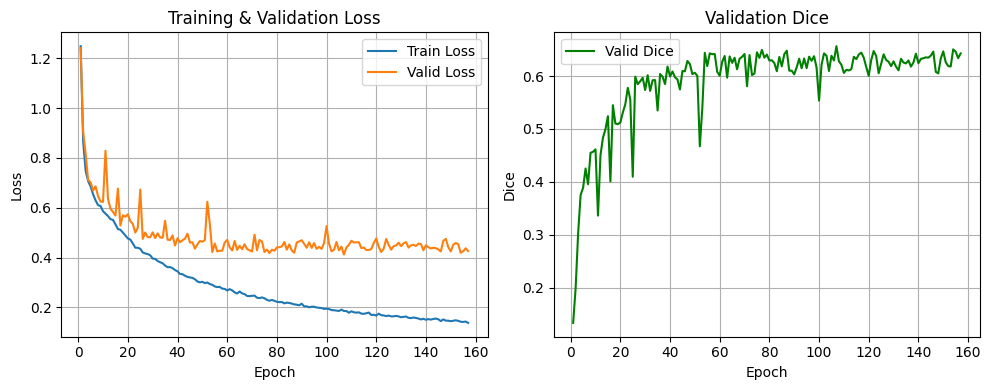

In [7]:
from src.utils import plot_loss_curves
plot_loss_curves(log_path='./logs/train_log_unetr_1.csv')